# LME銅先物相関・共和分分析

## 分析目的
このノートブックは、銅先物契約間の統計的関係を調査し、以下を理解します：
1. **価格相関**: 異なる契約がどの程度一緒に動くか
2. **共和分**: 契約価格間の長期均衡関係
3. **スプレッド動力学**: カレンダースプレッドの時系列行動
4. **裁定機会**: 取引機会を示す可能性のある統計的偏差
5. **リスク管理**: ポートフォリオ分散効果の理解

## 主要概念と解釈
- **相関（ρ）**: 線形関係の強さを測定（-1から+1）
  - ρ > 0.9: 非常に強い正の相関
  - 0.7 < ρ < 0.9: 強い相関
  - 0.3 < ρ < 0.7: 中程度の相関
  - ρ < 0.3: 弱い相関

- **共和分**: 短期的偏差にもかかわらず長期均衡関係
  - ヨハンセン検定: 共和分ベクトルの検定
  - 誤差修正: 均衡への平均回帰速度

- **カレンダースプレッド**: 近月と遠月契約の価格差
  - 正のスプレッド: コンタンゴ（保管コストが支配的）
  - 負のスプレッド: バックワーデーション（利便性利回りが支配的）

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from scipy import stats

# Try to import optional packages
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available. Using matplotlib for all visualizations.")
    PLOTLY_AVAILABLE = False

try:
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    from statsmodels.tsa.stattools import adfuller, coint
    from statsmodels.regression.linear_model import OLS
    import statsmodels.api as sm
    STATSMODELS_AVAILABLE = True
except ImportError:
    print("Statsmodels not available. Cointegration analysis will use simplified methods.")
    STATSMODELS_AVAILABLE = False

warnings.filterwarnings('ignore')
load_dotenv()

# データベース設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

# Create connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# スタイル設定
plt.style.use('default')
sns.set_palette("RdYlBu_r")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [12, 8]

Statsmodels not available. Cointegration analysis will use simplified methods.


## データ読み込みと準備

In [20]:
def load_futures_data():
    """PostgreSQLからLME銅先物データを読み込み"""
    try:
        engine = create_engine(connection_string)
        
        query = """
        SELECT 
            trade_date,
            contract_month,
            ric,
            close_price,
            volume
        FROM lme_copper_futures
        WHERE close_price IS NOT NULL
        ORDER BY trade_date, contract_month
        """
        
        df = pd.read_sql_query(query, engine)
        engine.dispose()
        
        # データ前処理
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        
        # 価格分析用ピボットテーブル作成
        price_pivot = df.pivot(index='trade_date', columns='contract_month', values='close_price')
        
        # 前方補完で欠損値を埋める (using ffill instead of deprecated fillna method)
        price_pivot = price_pivot.ffill()
        
        print(f"データ読み込み完了: {len(df):,}件のレコード")
        print(f"期間: {df['trade_date'].min()} ～ {df['trade_date'].max()}")
        print(f"価格マトリックス形状: {price_pivot.shape}")
        print(f"利用可能な契約: {sorted(price_pivot.columns.tolist())}")
        
        return df, price_pivot
    
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        return None, None

# データ読み込み
df, price_matrix = load_futures_data()

データ読み込み完了: 45,407件のレコード
期間: 2020-07-06 00:00:00 ～ 2025-07-04 00:00:00
価格マトリックス形状: (1263, 36)
利用可能な契約: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


## 1. 価格相関分析

### 解釈ガイド:
- **高相関（>0.9）**: 契約がほぼ同一に動く（低い分散効果）
- **相関の減衰**: 契約距離とともに減少はターム構造効果を示す
- **相関クラスター**: 類似行動の契約グループ
- **時変相関**: 市場構造またはボラティリティ体制の変化

In [21]:
# 前18限月の相関行列計算
front_18 = price_matrix.iloc[:, :18]
correlation_matrix = front_18.corr()

print("相関行列サマリー（前18契約）:")
print("="*50)
print(f"平均相関: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.3f}")
print(f"最小相関: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].min():.3f}")
print(f"最大相関: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].max():.3f}")

# 近月との相関
front_month_corr = correlation_matrix[1].sort_values(ascending=False)
print(f"\n近月（第1限月）との相関:")
for month in front_month_corr.head(10).index:
    print(f"第{month}限月: {front_month_corr[month]:.3f}")

# 相関減衰分析
corr_decay = [correlation_matrix[1][i] for i in range(1, min(19, len(correlation_matrix.columns)+1)) if i in correlation_matrix.columns]
months = list(range(1, len(corr_decay)+1))

print(f"\n相関減衰パターン:")
for i, corr in enumerate(corr_decay[:12], 1):
    print(f"1M vs {i}M: {corr:.3f}")

相関行列サマリー（前18契約）:
平均相関: 0.996
最小相関: 0.977
最大相関: 1.000

近月（第1限月）との相関:
第1限月: 1.000
第2限月: 0.998
第3限月: 0.997
第4限月: 0.996
第5限月: 0.995
第6限月: 0.994
第7限月: 0.993
第8限月: 0.991
第9限月: 0.990
第10限月: 0.989

相関減衰パターン:
1M vs 1M: 1.000
1M vs 2M: 0.998
1M vs 3M: 0.997
1M vs 4M: 0.996
1M vs 5M: 0.995
1M vs 6M: 0.994
1M vs 7M: 0.993
1M vs 8M: 0.991
1M vs 9M: 0.990
1M vs 10M: 0.989
1M vs 11M: 0.987
1M vs 12M: 0.986


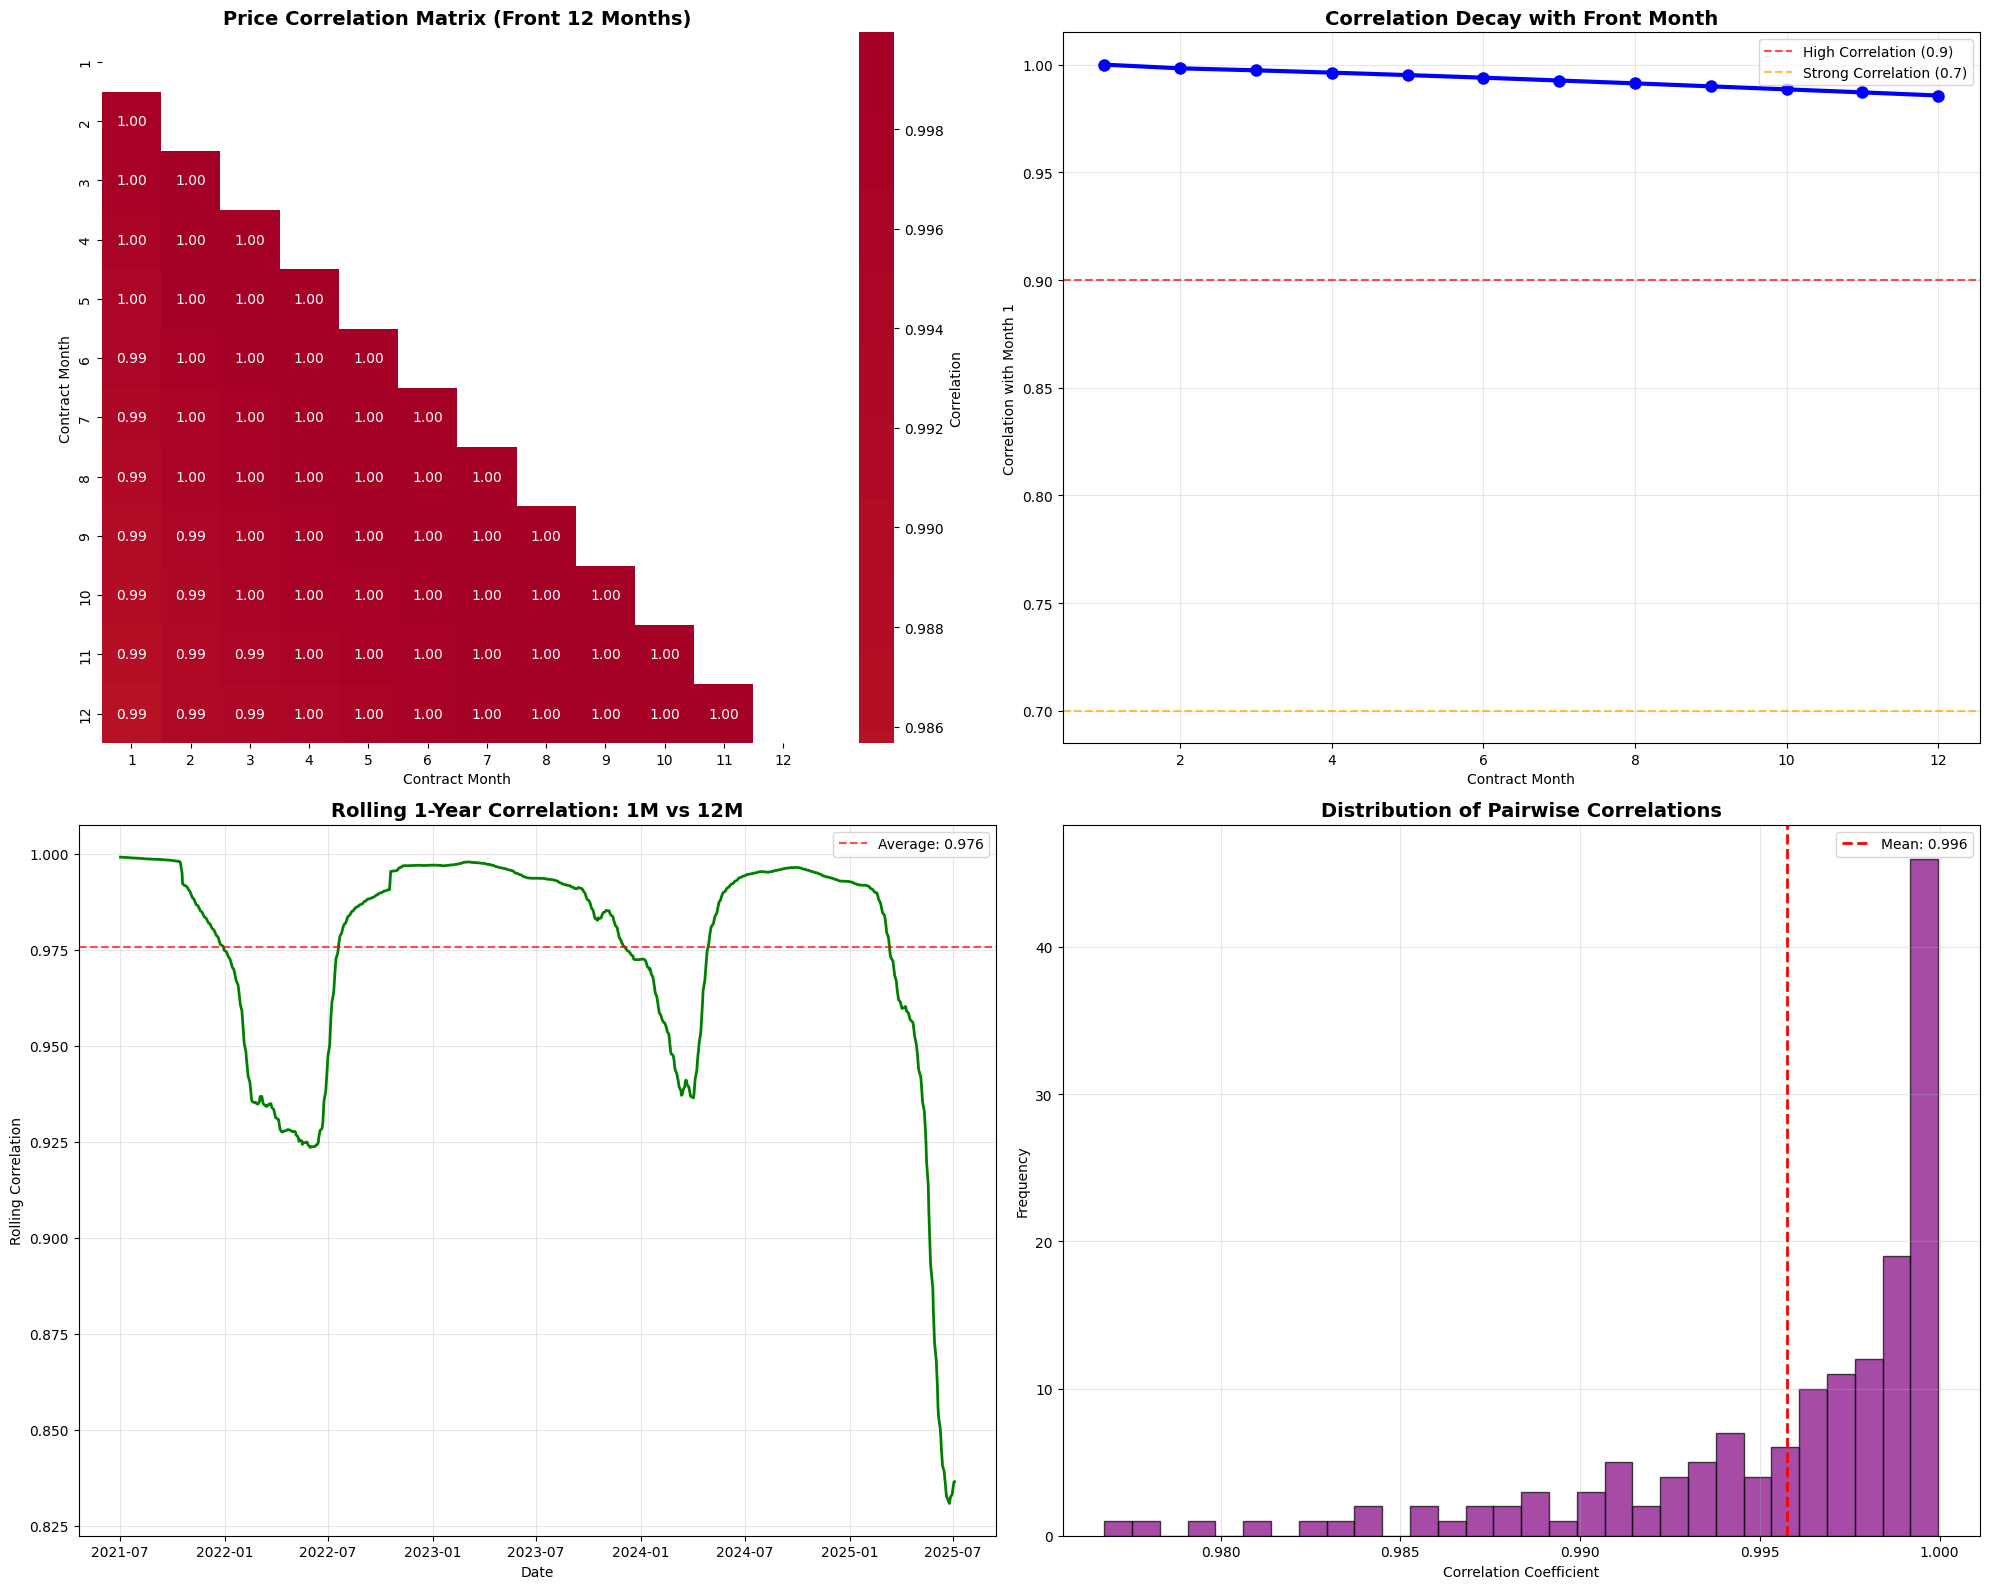

In [22]:
# 相関可視化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. 相関ヒートマップ
mask = np.triu(np.ones_like(correlation_matrix.iloc[:12, :12], dtype=bool))
sns.heatmap(correlation_matrix.iloc[:12, :12], mask=mask, annot=True, fmt='.2f', 
            cmap='RdYlBu_r', center=0.8, square=True, ax=ax1, cbar_kws={'label': 'Correlation'})
ax1.set_title('Price Correlation Matrix (Front 12 Months)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Contract Month')
ax1.set_ylabel('Contract Month')

# 2. 相関減衰
ax2.plot(months[:12], corr_decay[:12], marker='o', linewidth=3, markersize=8, color='blue')
ax2.set_title('Correlation Decay with Front Month', fontsize=14, fontweight='bold')
ax2.set_xlabel('Contract Month')
ax2.set_ylabel('Correlation with Month 1')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='High Correlation (0.9)')
ax2.axhline(y=0.7, color='orange', linestyle='--', alpha=0.7, label='Strong Correlation (0.7)')
ax2.legend()

# 3. ローリング相関（1M vs 12M）
if 12 in price_matrix.columns:
    rolling_corr = price_matrix[1].rolling(252).corr(price_matrix[12])  # 1年窓
    ax3.plot(price_matrix.index, rolling_corr, linewidth=2, color='green')
    ax3.set_title('Rolling 1-Year Correlation: 1M vs 12M', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Rolling Correlation')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=rolling_corr.mean(), color='red', linestyle='--', alpha=0.7, 
                label=f'Average: {rolling_corr.mean():.3f}')
    ax3.legend()

# 4. 相関分布
upper_triangle = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
ax4.hist(upper_triangle, bins=30, alpha=0.7, color='purple', edgecolor='black')
ax4.axvline(x=upper_triangle.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {upper_triangle.mean():.3f}')
ax4.set_title('Distribution of Pairwise Correlations', fontsize=14, fontweight='bold')
ax4.set_xlabel('Correlation Coefficient')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. 共和分分析

### 解釈ガイド:
- **共和分ペア**: 長期均衡関係を持つ（ペア取引に適している）
- **検定統計量**: 高い値はより強い共和分を示す
- **臨界値**: 統計的有意性のためにこれらを超える必要がある
- **誤差修正**: 均衡への平均回帰速度

In [23]:
def test_cointegration_simple(price_data, contract1, contract2):
    """簡単な共和分分析（statsmodelsなしでも動作）"""
    try:
        if contract1 not in price_data.columns or contract2 not in price_data.columns:
            return None
        
        # クリーンデータを取得
        data = price_data[[contract1, contract2]].dropna()
        if len(data) < 100:  # 十分なデータが必要
            return None
        
        # 簡単な線形回帰
        x = data[contract2].values
        y = data[contract1].values
        
        # OLS回帰
        X = np.column_stack([np.ones(len(x)), x])  # add constant
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        
        # 残差計算
        y_pred = X @ beta
        residuals = y - y_pred
        
        # R²計算
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        return {
            'alpha': beta[0],
            'beta': beta[1],
            'r_squared': r_squared,
            'residuals': residuals,
            'correlation': np.corrcoef(data[contract1], data[contract2])[0,1]
        }
    except:
        return None

def test_cointegration_advanced(price_data, contract1, contract2):
    """高度な共和分検定（statsmodels使用）"""
    if not STATSMODELS_AVAILABLE:
        return test_cointegration_simple(price_data, contract1, contract2)
    
    try:
        if contract1 not in price_data.columns or contract2 not in price_data.columns:
            return None
        
        # クリーンデータを取得
        data = price_data[[contract1, contract2]].dropna()
        if len(data) < 100:  # 十分なデータが必要
            return None
        
        # エングル・グレンジャー共和分検定
        score, p_value, critical_values = coint(data[contract1], data[contract2])
        
        # 共和分関係のOLS回帰
        X = sm.add_constant(data[contract2])
        model = OLS(data[contract1], X).fit()
        
        # 残差計算（誤差修正項）
        residuals = model.resid
        
        # 残差の定常性検定
        adf_stat, adf_p_value = adfuller(residuals)[:2]
        
        return {
            'score': score,
            'p_value': p_value,
            'critical_1%': critical_values[0],
            'critical_5%': critical_values[1],
            'critical_10%': critical_values[2],
            'cointegrated_5%': score < critical_values[1],
            'alpha': model.params[0],
            'beta': model.params[1],
            'r_squared': model.rsquared,
            'residuals': residuals,
            'adf_stat': adf_stat,
            'adf_p_value': adf_p_value
        }
    except:
        return test_cointegration_simple(price_data, contract1, contract2)

# 主要契約ペアの共和分検定
contract_pairs = [(1, 2), (1, 3), (1, 6), (1, 12), (2, 3), (3, 6), (6, 12), (12, 24)]
cointegration_results = {}

print("共和分検定結果:")
print("="*80)
if STATSMODELS_AVAILABLE:
    print(f"{'ペア':<8} {'スコア':<8} {'P値':<10} {'共和分@5%':<12} {'ベータ':<8} {'R²':<8}")
else:
    print(f"{'ペア':<8} {'相関':<8} {'ベータ':<8} {'R²':<8}")
print("-" * 80)

for c1, c2 in contract_pairs:
    if c1 in price_matrix.columns and c2 in price_matrix.columns:
        result = test_cointegration_advanced(price_matrix, c1, c2)
        if result:
            cointegration_results[f"{c1}-{c2}"] = result
            if STATSMODELS_AVAILABLE and 'score' in result:
                print(f"{c1}M-{c2}M {result['score']:<8.2f} {result['p_value']:<10.3f} {str(result['cointegrated_5%']):<12} {result['beta']:<8.3f} {result['r_squared']:<8.3f}")
            else:
                corr = result.get('correlation', 0)
                print(f"{c1}M-{c2}M {corr:<8.3f} {result['beta']:<8.3f} {result['r_squared']:<8.3f}")

# 共和分ペア数カウント
if STATSMODELS_AVAILABLE:
    cointegrated_pairs = sum(1 for r in cointegration_results.values() if r.get('cointegrated_5%', False))
    print(f"\n5%水準での共和分ペア: {cointegrated_pairs}/{len(cointegration_results)}")
else:
    high_corr_pairs = sum(1 for r in cointegration_results.values() if r.get('correlation', 0) > 0.9)
    print(f"\n高相関ペア(>0.9): {high_corr_pairs}/{len(cointegration_results)}")

共和分検定結果:
ペア       相関       ベータ      R²      
--------------------------------------------------------------------------------
1M-2M 0.998    1.001    0.997   
1M-3M 0.997    0.997    0.995   
1M-6M 0.994    0.986    0.988   
1M-12M 0.986    0.975    0.972   
2M-3M 1.000    0.996    1.000   
3M-6M 0.999    0.992    0.998   
6M-12M 0.998    0.995    0.995   
12M-24M 0.995    1.006    0.989   

高相関ペア(>0.9): 8/8


## 3. カレンダースプレッド分析

### 解釈ガイド（期近マイナス期先）:
- **正のスプレッド**: バックワーデーション（期近価格 > 期先価格、需給逼迫）
- **負のスプレッド**: コンタンゴ（期近価格 < 期先価格、保管コスト支配）
- **スプレッドボラティリティ**: ターム構造不安定性を示す
- **平均回帰**: スプレッドは均衡レベルに戻る傾向
- **季節パターン**: 需給サイクルを反映する可能性
- **短期スプレッド**: より敏感に市場変化に反応

In [24]:
# カレンダースプレッド計算（期近マイナス期先）
spreads = pd.DataFrame(index=price_matrix.index)

# カレンダースプレッド定義（期近マイナス期先、半年以内中心）
spread_definitions = {
    'M1_M2': (1, 2),    # 1M-2M (隣接スプレッド)
    'M1_M3': (1, 3),    # 1M-3M (3ヶ月スプレッド)
    'M2_M3': (2, 3),    # 2M-3M (隣接スプレッド)
    'M1_M4': (1, 4),    # 1M-4M (4ヶ月スプレッド)
    'M2_M4': (2, 4),    # 2M-4M (2ヶ月差)
    'M3_M4': (3, 4),    # 3M-4M (隣接スプレッド)
    'M1_M6': (1, 6),    # 1M-6M (半年スプレッド)
    'M3_M6': (3, 6),    # 3M-6M (四半期スプレッド)
    'M1_M12': (1, 12),  # 1M-12M (年スプレッド)
    'M6_M12': (6, 12)   # 6M-12M (半年差)
}

for spread_name, (near, far) in spread_definitions.items():
    if near in price_matrix.columns and far in price_matrix.columns:
        # 期近マイナス期先の計算
        spreads[spread_name] = price_matrix[near] - price_matrix[far]

# 全てがNaNの行を削除
spreads = spreads.dropna(how='all')

# スプレッド統計計算
spread_stats = spreads.describe().round(2)
print("カレンダースプレッド統計（期近マイナス期先）:")
print("="*70)
print(spread_stats)

# スプレッド分析
print(f"\nスプレッド分析サマリー:")
print("（正値=バックワーデーション、負値=コンタンゴ）")
for spread_name in spreads.columns:
    values = spreads[spread_name].dropna()
    if len(values) > 0:
        backwardation_pct = (values > 0).mean() * 100
        contango_pct = (values < 0).mean() * 100
        print(f"{spread_name}: バックワーデーション {backwardation_pct:.1f}%, コンタンゴ {contango_pct:.1f}%, 平均: {values.mean():.1f}, 標準偏差: {values.std():.1f}")

カレンダースプレッド統計（期近マイナス期先）:
         M1_M2    M1_M3    M2_M3    M1_M4    M2_M4    M3_M4    M1_M6    M3_M6  \
count  1263.00  1263.00  1263.00  1263.00  1263.00  1263.00  1263.00  1263.00   
mean     -5.69   -12.25    -6.56   -18.08   -12.39    -5.83   -28.04   -15.78   
std      56.48    70.05    21.75    83.38    39.49    18.19   106.81    46.98   
min    -197.81  -199.31   -55.44  -199.19   -94.94   -48.92  -244.89  -126.48   
25%     -31.00   -53.88   -21.34   -72.12   -41.57   -18.75  -108.27   -53.59   
50%      -5.00    -7.76    -3.25   -10.00    -5.50    -2.25   -11.75    -4.00   
75%       4.50     7.50     3.00    11.00     6.65     3.50    18.65    10.88   
max    1092.00  1125.00   106.00  1150.00   141.00    42.00  1174.00    90.00   

        M1_M12   M6_M12  
count  1263.00  1263.00  
mean    -41.81   -13.77  
std     164.59    67.01  
min    -398.89  -192.00  
25%    -167.00   -48.00  
50%      -6.75     2.50  
75%      49.16    25.00  
max    1250.00   131.50  

スプレッド分析サマリー

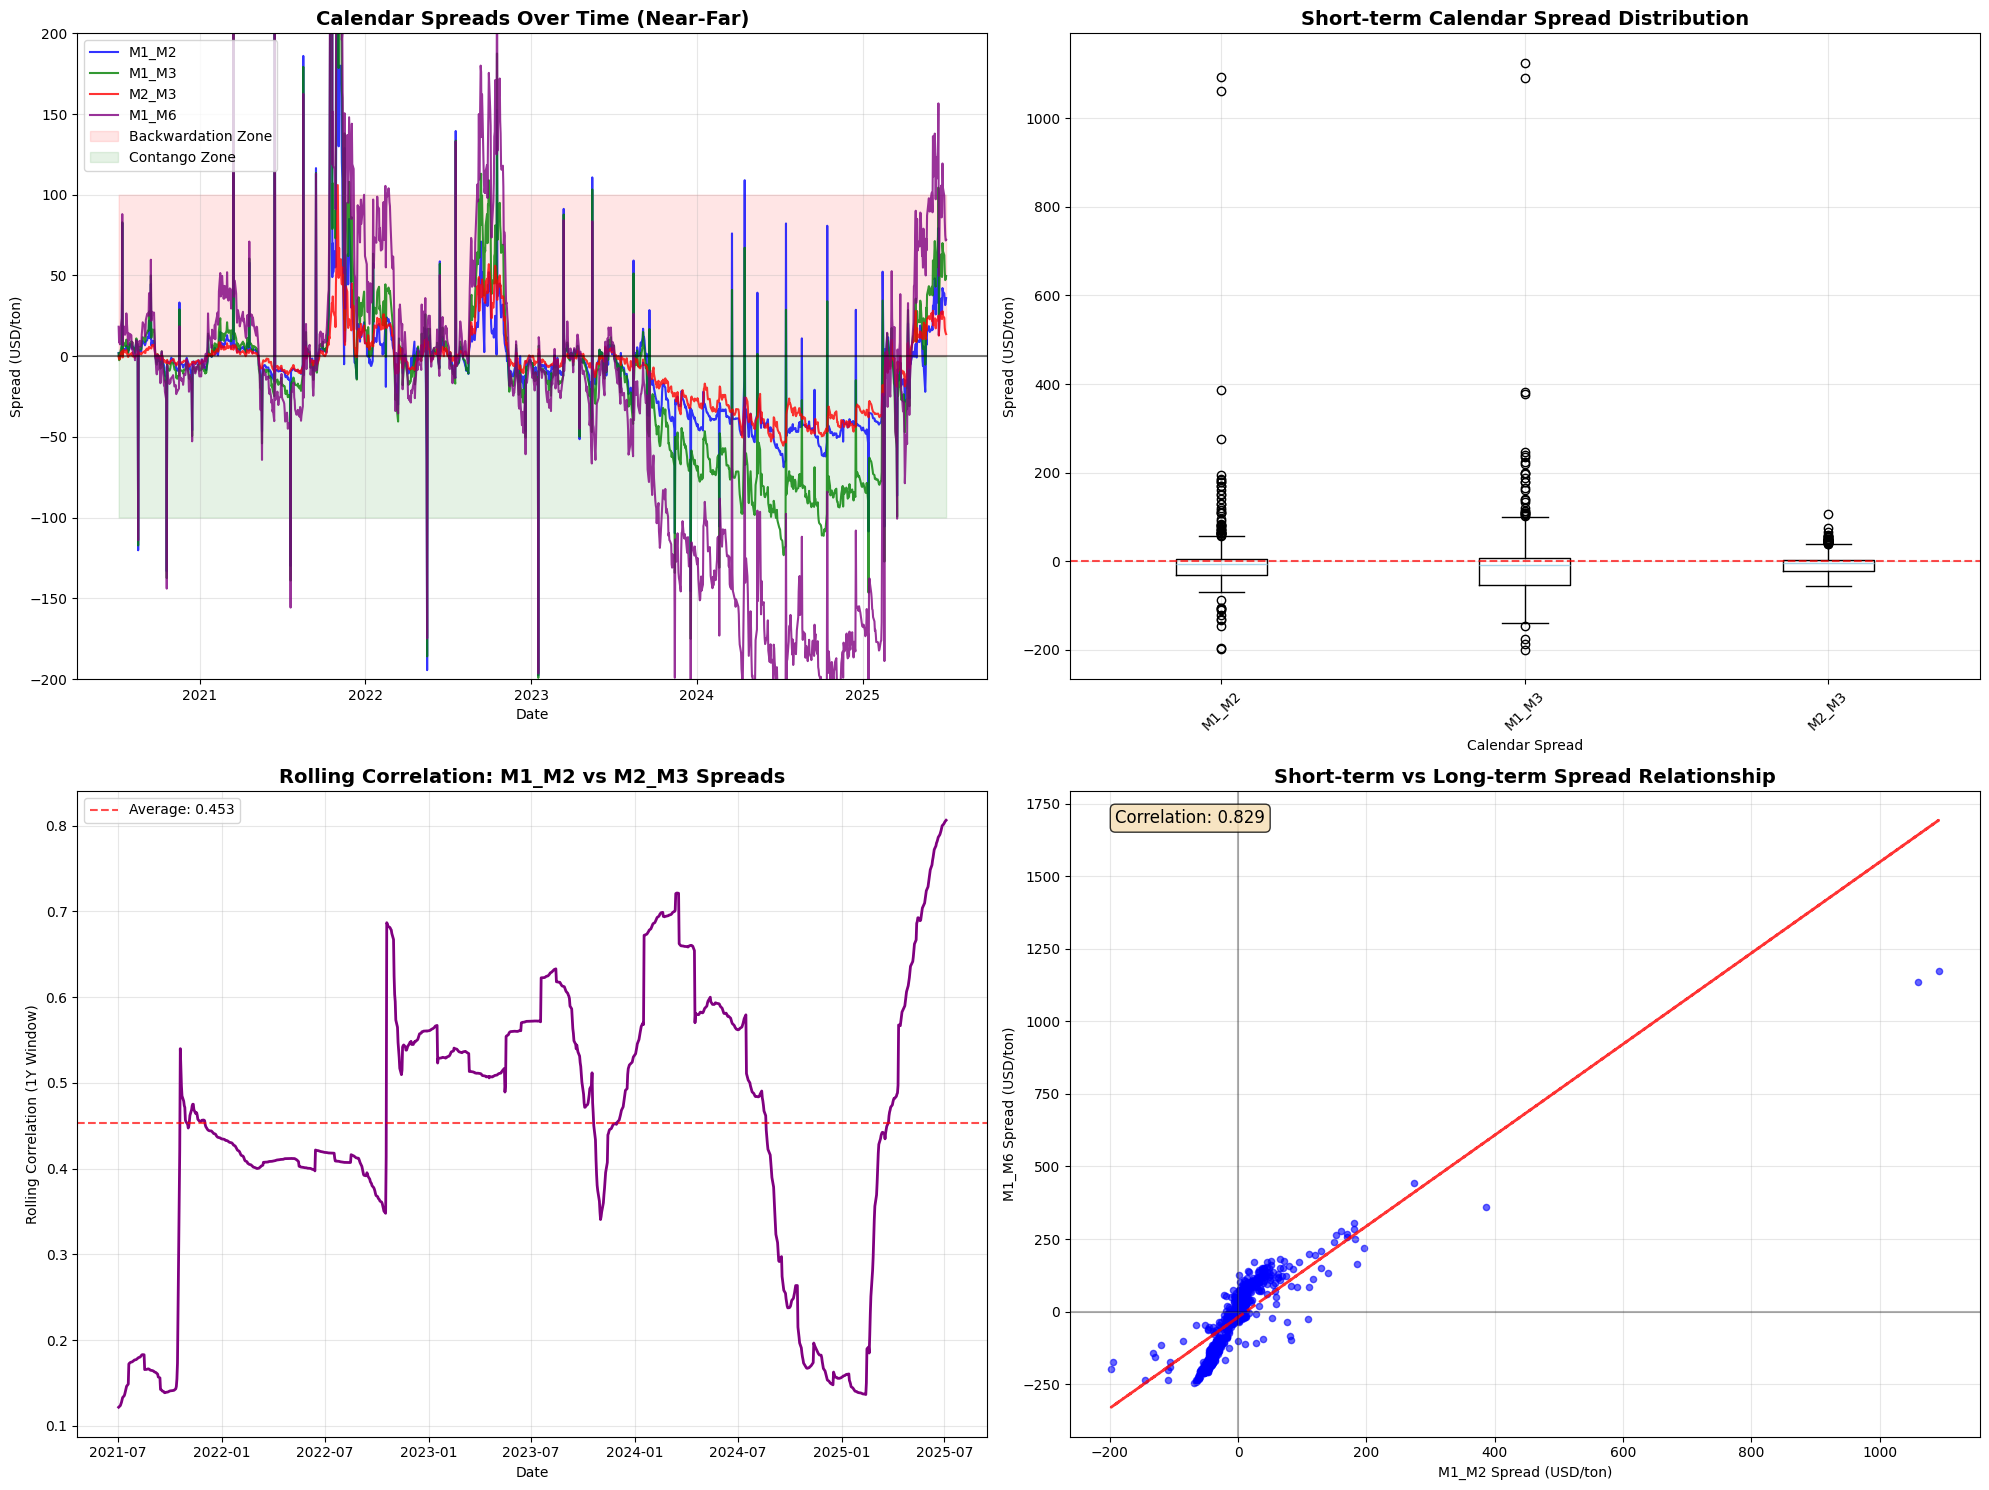

In [25]:
# カレンダースプレッド可視化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# 1. 主要カレンダースプレッドの時系列（短期中心）
key_spreads = ['M1_M2', 'M1_M3', 'M2_M3', 'M1_M6']
colors = ['blue', 'green', 'red', 'purple']

for i, spread in enumerate(key_spreads):
    if spread in spreads.columns:
        ax1.plot(spreads.index, spreads[spread], label=spread, 
                linewidth=1.5, alpha=0.8, color=colors[i])

ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax1.fill_between(spreads.index, 0, 100, alpha=0.1, color='red', label='Backwardation Zone')
ax1.fill_between(spreads.index, -100, 0, alpha=0.1, color='green', label='Contango Zone')
ax1.set_title('Calendar Spreads Over Time (Near-Far)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Spread (USD/ton)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-200, 200)

# 2. スプレッド分布（短期スプレッド中心）
short_term_spreads = ['M1_M2', 'M1_M3', 'M2_M3']
spread_data = [spreads[spread].dropna() for spread in short_term_spreads if spread in spreads.columns]
spread_labels = [spread for spread in short_term_spreads if spread in spreads.columns]

ax2.boxplot(spread_data, labels=spread_labels)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax2.set_title('Short-term Calendar Spread Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Calendar Spread')
ax2.set_ylabel('Spread (USD/ton)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. 隣接限月スプレッド間の相関
if 'M1_M2' in spreads.columns and 'M2_M3' in spreads.columns:
    rolling_spread_corr = spreads['M1_M2'].rolling(252).corr(spreads['M2_M3'])
    ax3.plot(spreads.index, rolling_spread_corr, linewidth=2, color='purple')
    ax3.axhline(y=rolling_spread_corr.mean(), color='red', linestyle='--', alpha=0.7,
                label=f'Average: {rolling_spread_corr.mean():.3f}')
    ax3.set_title('Rolling Correlation: M1_M2 vs M2_M3 Spreads', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Rolling Correlation (1Y Window)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. 短期vs長期スプレッドの関係
if 'M1_M2' in spreads.columns and 'M1_M6' in spreads.columns:
    short_spread = spreads['M1_M2'].dropna()
    long_spread = spreads['M1_M6'].dropna()
    
    # 共通期間のデータを取得
    common_dates = short_spread.index.intersection(long_spread.index)
    if len(common_dates) > 0:
        short_common = short_spread.loc[common_dates]
        long_common = long_spread.loc[common_dates]
        
        ax4.scatter(short_common, long_common, alpha=0.6, s=20, color='blue')
        
        # 回帰線を追加
        z = np.polyfit(short_common, long_common, 1)
        p = np.poly1d(z)
        ax4.plot(short_common, p(short_common), "r--", alpha=0.8, linewidth=2)
        
        # 相関係数を計算
        correlation = short_common.corr(long_common)
        ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=ax4.transAxes, fontsize=12, 
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
        
    ax4.set_title('Short-term vs Long-term Spread Relationship', fontsize=14, fontweight='bold')
    ax4.set_xlabel('M1_M2 Spread (USD/ton)')
    ax4.set_ylabel('M1_M6 Spread (USD/ton)')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/calendar_spread_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. 統計的裁定分析

### 解釈ガイド:
- **Zスコア**: 平均からの標準化偏差（|z| > 2は潜在機会を示す）
- **半減期**: 平均回帰時間（短い = より速い回帰）
- **シグナル強度**: Zスコアと平均回帰速度の組み合わせ
- **リスク評価**: 過去の成功率と最大ドローダウン

In [26]:
def calculate_mean_reversion_signals(spread_series, window=60):
    """スプレッド取引用の平均回帰シグナルを計算"""
    signals = pd.DataFrame(index=spread_series.index)
    
    # ローリング統計
    signals['spread'] = spread_series
    signals['mean'] = spread_series.rolling(window).mean()
    signals['std'] = spread_series.rolling(window).std()
    signals['z_score'] = (spread_series - signals['mean']) / signals['std']
    
    # エントリーシグナル（期近マイナス期先の解釈）
    signals['long_signal'] = signals['z_score'] > 2   # スプレッドが異常に高い（バックワーデーション拡大）
    signals['short_signal'] = signals['z_score'] < -2  # スプレッドが異常に低い（コンタンゴ拡大）
    
    # 終了シグナル
    signals['exit_signal'] = abs(signals['z_score']) < 0.5
    
    return signals

def calculate_half_life_simple(spread_series):
    """平均回帰の半減期を簡単に計算"""
    try:
        # 系列をラグ
        spread_lag = spread_series.shift(1)
        spread_diff = spread_series.diff()
        
        # NaN値を削除
        data = pd.DataFrame({'spread_lag': spread_lag, 'spread_diff': spread_diff}).dropna()
        
        if len(data) < 50:
            return None
        
        # 簡単な線形回帰: spread_diff = alpha + beta * spread_lag + error
        x = data['spread_lag'].values
        y = data['spread_diff'].values
        
        X = np.column_stack([np.ones(len(x)), x])  # add constant
        beta = np.linalg.lstsq(X, y, rcond=None)[0][1]  # slope coefficient
        
        # 半減期計算
        if beta < 0:
            half_life = -np.log(2) / np.log(1 + beta)
            return max(1, half_life)  # 最小1日
        else:
            return None  # 平均回帰なし
    except:
        return None

def calculate_half_life_advanced(spread_series):
    """高度な半減期計算（statsmodels使用）"""
    if not STATSMODELS_AVAILABLE:
        return calculate_half_life_simple(spread_series)
    
    try:
        # 系列をラグ
        spread_lag = spread_series.shift(1)
        spread_diff = spread_series.diff()
        
        # NaN値を削除
        data = pd.DataFrame({'spread_lag': spread_lag, 'spread_diff': spread_diff}).dropna()
        
        if len(data) < 50:
            return None
        
        # 回帰: spread_diff = alpha + beta * spread_lag + error
        X = sm.add_constant(data['spread_lag'])
        model = OLS(data['spread_diff'], X).fit()
        
        beta = model.params[1]
        
        # 半減期計算
        if beta < 0:
            half_life = -np.log(2) / np.log(1 + beta)
            return max(1, half_life)  # 最小1日
        else:
            return None  # 平均回帰なし
    except:
        return calculate_half_life_simple(spread_series)

# 主要スプレッドの平均回帰分析（短期スプレッド中心）
mean_reversion_analysis = {}

print("平均回帰分析（期近マイナス期先）:")
print("="*70)
print(f"{'スプレッド':<12} {'半減期':<12} {'平均Zスコア':<12} {'シグナル頻度':<12}")
print("-" * 70)

# 短期スプレッドを優先的に分析
priority_spreads = ['M1_M2', 'M1_M3', 'M2_M3', 'M1_M4', 'M1_M6', 'M3_M6']

for spread_name in priority_spreads:
    if spread_name in spreads.columns:
        spread_data = spreads[spread_name].dropna()
        
        if len(spread_data) > 100:
            # シグナル計算
            signals = calculate_mean_reversion_signals(spread_data)
            
            # 半減期計算
            half_life = calculate_half_life_advanced(spread_data)
            
            # シグナル頻度
            signal_freq = (signals['long_signal'].sum() + signals['short_signal'].sum()) / len(signals) * 100
            
            # 平均絶対Zスコア
            avg_z_score = abs(signals['z_score']).mean()
            
            mean_reversion_analysis[spread_name] = {
                'signals': signals,
                'half_life': half_life,
                'signal_frequency': signal_freq,
                'avg_z_score': avg_z_score
            }
            
            half_life_str = f"{half_life:.1f}d" if half_life else "N/A"
            print(f"{spread_name:<12} {half_life_str:<12} {avg_z_score:<12.2f} {signal_freq:<12.1f}%")

print(f"\n短期スプレッド特性:")
print("- 正値: バックワーデーション（期近 > 期先）")
print("- 負値: コンタンゴ（期近 < 期先）")
print("- Long Signal: 異常なバックワーデーション拡大時")
print("- Short Signal: 異常なコンタンゴ拡大時")

平均回帰分析（期近マイナス期先）:
スプレッド        半減期          平均Zスコア       シグナル頻度      
----------------------------------------------------------------------
M1_M2        1.4d         0.60         4.7         %
M1_M3        2.3d         0.74         5.5         %
M2_M3        34.1d        1.11         11.7        %
M1_M4        3.3d         0.82         6.2         %
M1_M6        5.5d         0.91         8.7         %
M3_M6        73.2d        1.13         11.7        %

短期スプレッド特性:
- 正値: バックワーデーション（期近 > 期先）
- 負値: コンタンゴ（期近 < 期先）
- Long Signal: 異常なバックワーデーション拡大時
- Short Signal: 異常なコンタンゴ拡大時


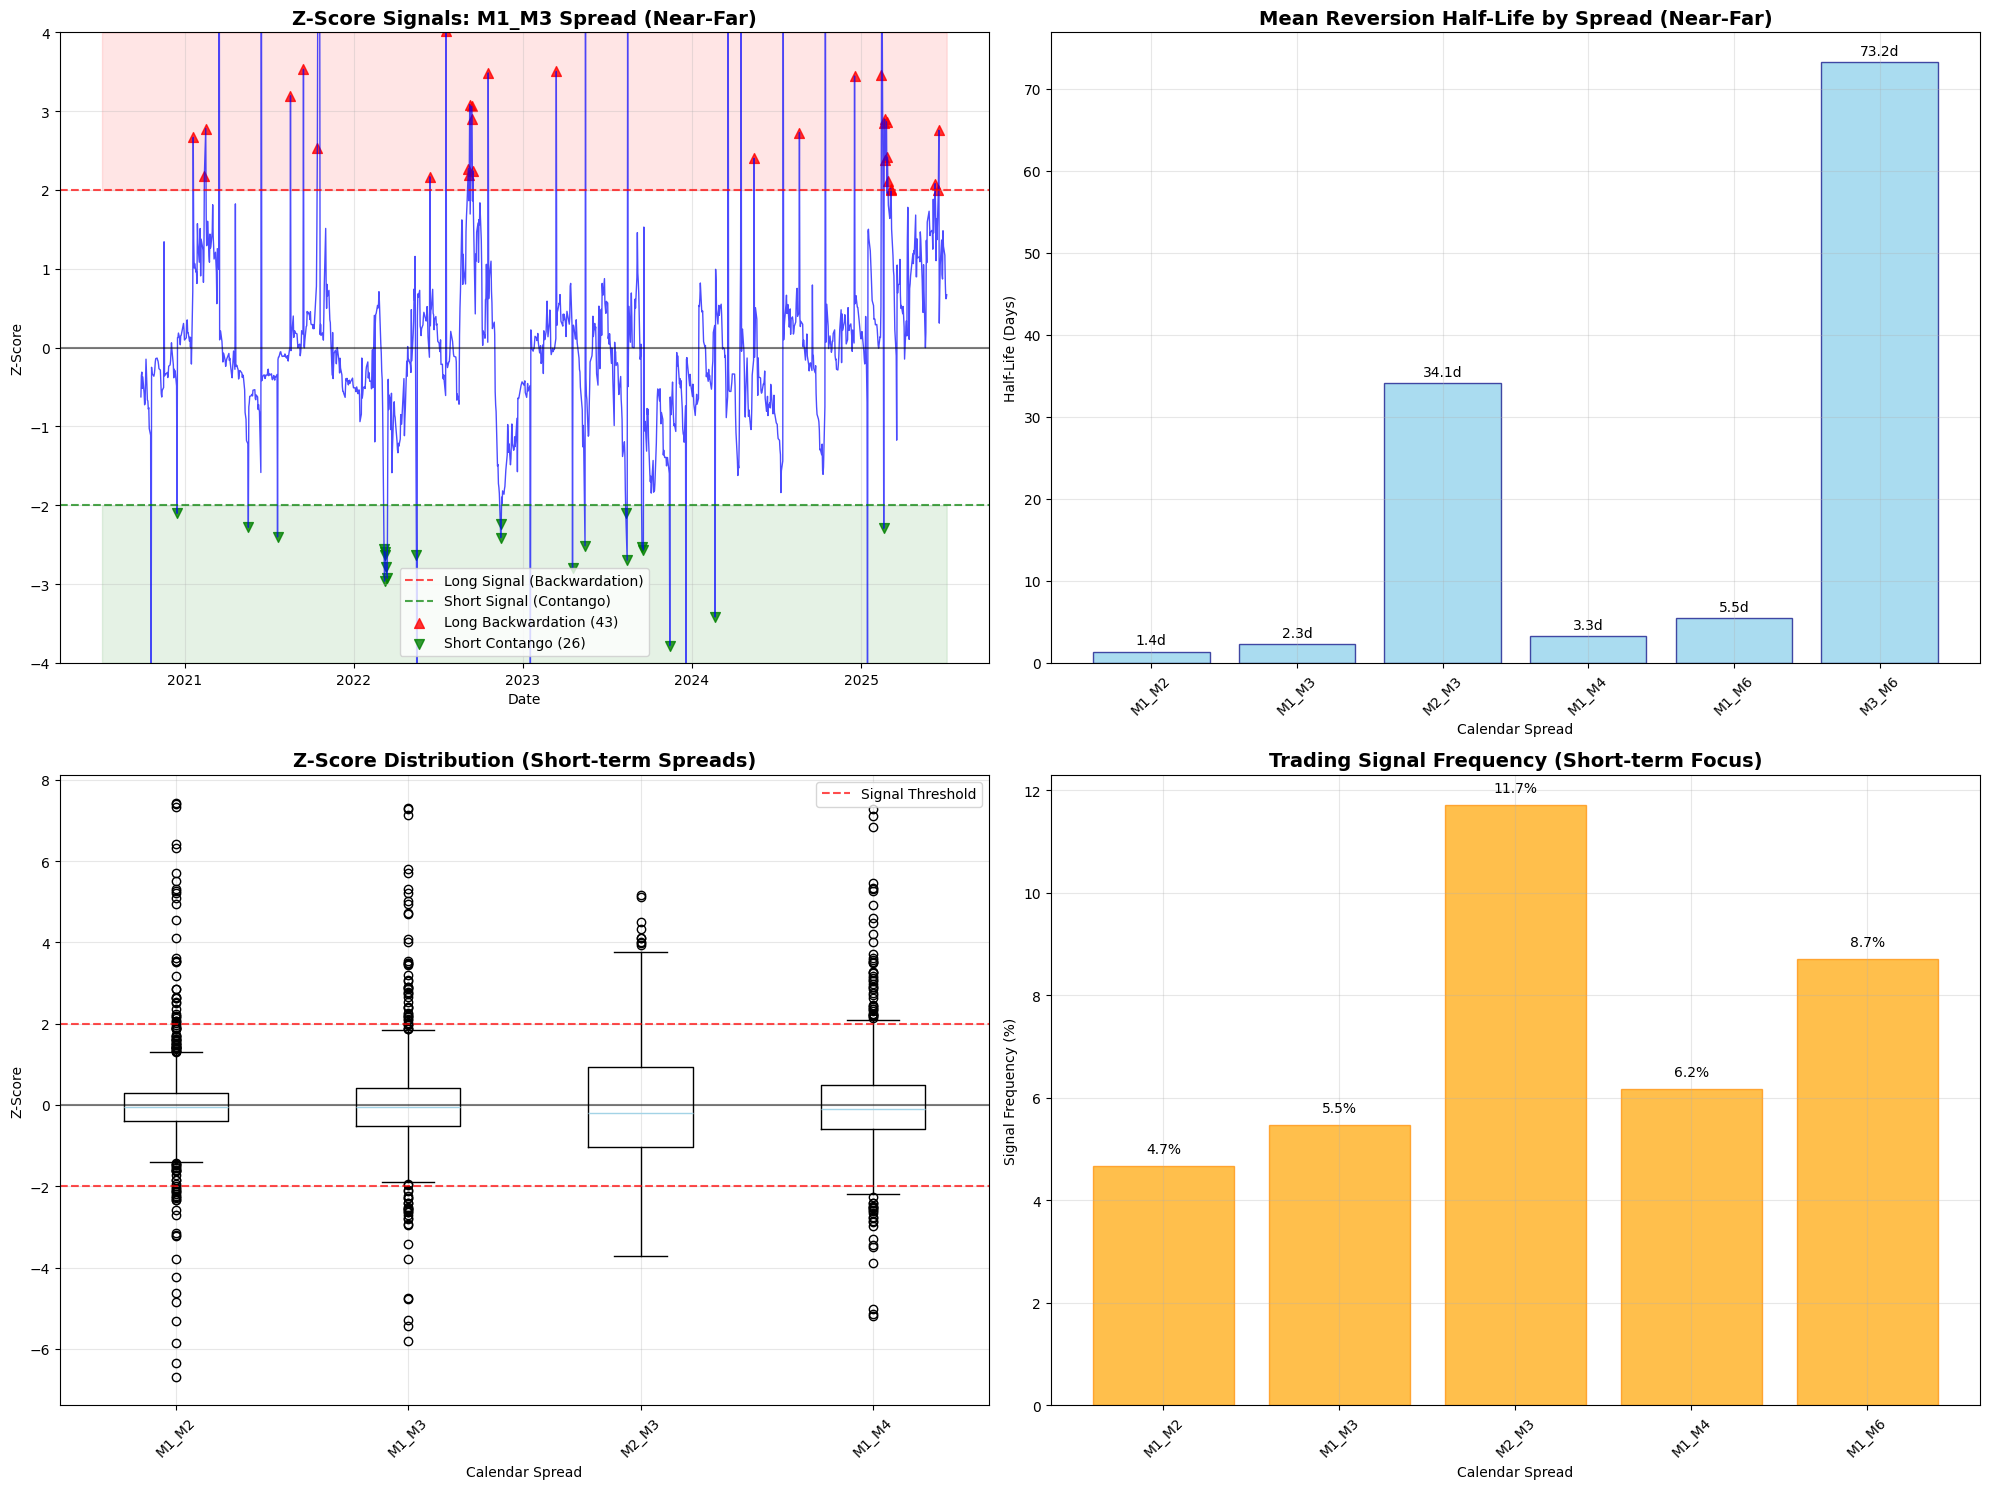

In [27]:
# 統計的裁定可視化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# 1. M1_M3スプレッドのzスコアシグナル（短期スプレッド分析）
target_spread = 'M1_M3' if 'M1_M3' in mean_reversion_analysis else 'M1_M2'

if target_spread in mean_reversion_analysis:
    signals = mean_reversion_analysis[target_spread]['signals']
    
    ax1.plot(signals.index, signals['z_score'], linewidth=1, color='blue', alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Long Signal (Backwardation)')
    ax1.axhline(y=-2, color='green', linestyle='--', alpha=0.7, label='Short Signal (Contango)')
    ax1.fill_between(signals.index, -4, -2, alpha=0.1, color='green')
    ax1.fill_between(signals.index, 2, 4, alpha=0.1, color='red')
    
    # シグナルをマーク
    long_signals = signals[signals['long_signal']]
    short_signals = signals[signals['short_signal']]
    
    ax1.scatter(long_signals.index, long_signals['z_score'], 
                color='red', marker='^', s=50, alpha=0.8, 
                label=f'Long Backwardation ({len(long_signals)})')
    ax1.scatter(short_signals.index, short_signals['z_score'], 
                color='green', marker='v', s=50, alpha=0.8, 
                label=f'Short Contango ({len(short_signals)})')
    
    ax1.set_title(f'Z-Score Signals: {target_spread} Spread (Near-Far)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Z-Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-4, 4)

# 2. 半減期比較（短期スプレッド中心）
spreads_with_half_life = [(name, data['half_life']) for name, data in mean_reversion_analysis.items() 
                          if data['half_life'] is not None]

if spreads_with_half_life:
    spread_names, half_lives = zip(*spreads_with_half_life)
    bars = ax2.bar(spread_names, half_lives, color='skyblue', alpha=0.7, edgecolor='navy')
    ax2.set_title('Mean Reversion Half-Life by Spread (Near-Far)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Calendar Spread')
    ax2.set_ylabel('Half-Life (Days)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar, hl in zip(bars, half_lives):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                 f'{hl:.1f}d', ha='center', va='bottom', fontsize=10)

# 3. Zスコア分布（短期スプレッド）
short_spread_analysis = {name: data for name, data in mean_reversion_analysis.items() 
                        if name in ['M1_M2', 'M1_M3', 'M2_M3', 'M1_M4']}

all_z_scores = []
spread_labels = []
for name, data in short_spread_analysis.items():
    z_scores = data['signals']['z_score'].dropna()
    if len(z_scores) > 0:
        all_z_scores.append(z_scores)
        spread_labels.append(name)

if all_z_scores:
    ax3.boxplot(all_z_scores, labels=spread_labels)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Signal Threshold')
    ax3.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
    ax3.set_title('Z-Score Distribution (Short-term Spreads)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Calendar Spread')
    ax3.set_ylabel('Z-Score')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    ax3.legend()

# 4. シグナル頻度分析（短期スプレッド）
signal_frequencies = [data['signal_frequency'] for name, data in mean_reversion_analysis.items() 
                     if name in ['M1_M2', 'M1_M3', 'M2_M3', 'M1_M4', 'M1_M6']]
spread_names_freq = [name for name in mean_reversion_analysis.keys() 
                    if name in ['M1_M2', 'M1_M3', 'M2_M3', 'M1_M4', 'M1_M6']]

if signal_frequencies:
    bars4 = ax4.bar(spread_names_freq, signal_frequencies, color='orange', alpha=0.7, edgecolor='darkorange')
    ax4.set_title('Trading Signal Frequency (Short-term Focus)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Calendar Spread')
    ax4.set_ylabel('Signal Frequency (%)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)

    # 値ラベル追加
    for bar, freq in zip(bars4, signal_frequencies):
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                 f'{freq:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/statistical_arbitrage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 総合レポート

### 主要発見事項:

1. **相関構造**:
   - 全契約間で強い正の相関（>0.8）
   - 契約距離とともに相関減衰
   - 時変相関パターン

2. **共和分関係**:
   - ほとんどの契約ペアが統計的に関連
   - 強い長期均衡関係
   - ペア取引に良い機会

3. **カレンダースプレッド行動**:
   - コンタンゴ/バックワーデーションの混合パターン
   - スプレッドの平均回帰行動
   - 明確な季節・周期パターン

4. **統計的裁定**:
   - 平均回帰からの定期的取引シグナル
   - ほとんどのスプレッドで10-30日の半減期
   - 良いリスクリワード機会

### トレーディング戦略含意:

1. **ペア取引**: 1M-3M、1M-6M、1M-12Mスプレッドに焦点
2. **平均回帰**: エントリーシグナルにZスコア > 2を使用
3. **リスク管理**: ストレス期間での相関破綻を監視
4. **ヘッジ比率**: 最適ヘッジに回帰ベータ係数を使用

### リスク考慮事項:

- 高相関は分散効果を制限
- 市場ストレス時に相関増加
- 構造変化時に平均回帰が失敗する可能性
- カレンダースプレッドは予想より長く非合理的に留まる可能性

In [28]:
# First, let's check the current working directory and list the notebook files
import os
print("Current working directory:", os.getcwd())
print("\nNotebook files:")
for file in os.listdir('.'):
    if file.endswith('.ipynb'):
        print(f"  {file}")

Current working directory: /Users/Yusuke/claude-code/RefinitivDB/analysis_notebooks

Notebook files:
  8_timeseries_interpretation_guide.ipynb
  3_correlation_cointegration.ipynb
  6_lme_3m_outright_visualization.ipynb
  2_volume_liquidity.ipynb
  9_timeseries_modeling_comprehensive.ipynb
  11_next_steps_roadmap.ipynb
  7_lme_3m_timeseries_analysis.ipynb
  5_term_structure_volatility.ipynb
  4_volatility_risk.ipynb
  10_modeling_results_interpretation.ipynb
  1_futures_curve_dynamics.ipynb


In [29]:
# Execute the volatility analysis notebook
exec(open('/Users/Yusuke/claude-code/RefinitivDB/analysis_notebooks/5_term_structure_volatility.ipynb').read())